In [288]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy as sp
from skimage import measure
from scipy import ndimage

In [289]:
#path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/2000/'
path = '/users/davidle/scratch/PW/2016/' #Path for Daint

In [290]:
PW = xr.open_mfdataset(path+'??PW.nc')

/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [291]:
PW

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 8784)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Data variables:
    tcwv       (time, latitude, longitude) float32 dask.array<shape=(8784, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-27 20:41:28 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

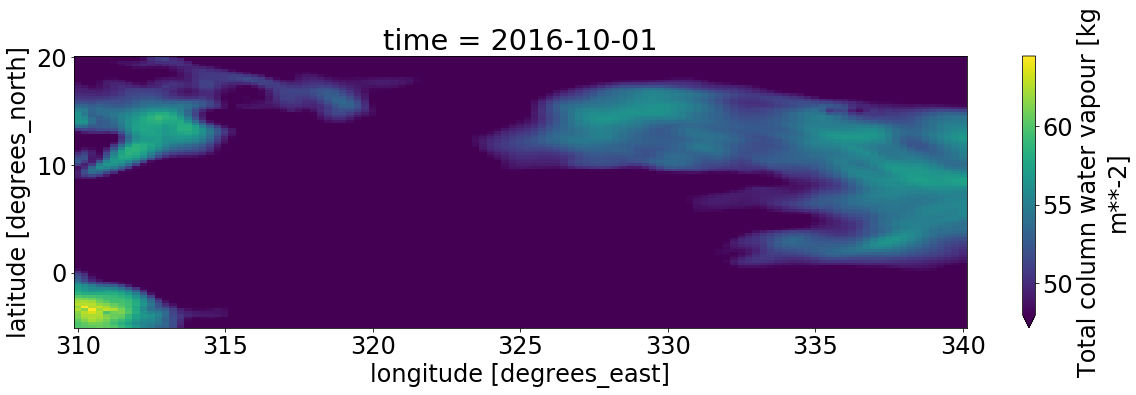

In [292]:
plt.figure(figsize=(20,5))
PW.tcwv.sel({'time':'2016-10-1T00:00:00', 'latitude':slice(20,-5),'longitude':slice(310,340)}).plot(vmin=48)
plt.rcParams.update({'font.size': 24})


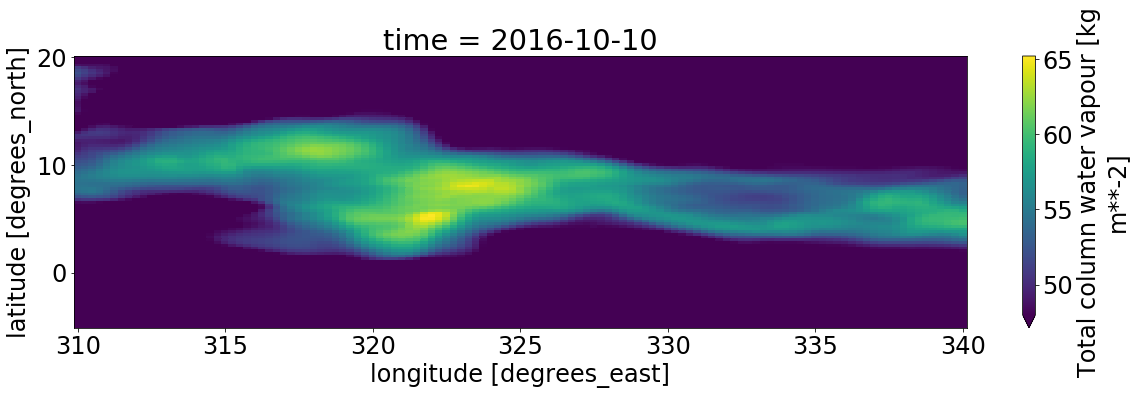

In [296]:
plt.figure(figsize=(20,5))
PW.tcwv.sel({'time':'2016-10-10T00:00:00', 'latitude':slice(20,-5),'longitude':slice(310,340)}).plot(vmin=48)
plt.rcParams.update({'font.size': 24})

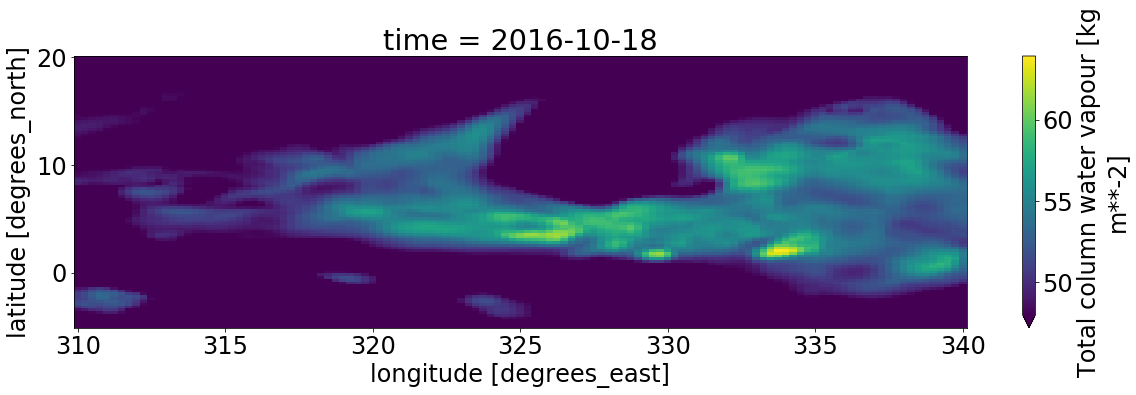

In [294]:
plt.figure(figsize=(20,5))
PW.tcwv.sel({'time':'2016-10-18T00:00:00', 'latitude':slice(20,-5),'longitude':slice(310,340)}).plot(vmin=48)
plt.rcParams.update({'font.size': 24})

In [63]:
def find_separation_bin(field,vmin=45,vmax=55,bins=100):
# Inputs
# field = field from which to take the pdf
# vmin = minimal value of the interval over which min(PDF) will be searched
# vmax = maximal value //
# bins = Number of bins of the PDF

    field_hist,bin_edges = np.histogram(field.flatten(),bins=bins)
    bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

    binary = (bin_mid<vmax)*(bin_mid>vmin)
    imin =  np.argmin(field_hist[binary])+np.argmax(binary)

    return bin_mid[imin],bin_mid

In [64]:
CWV_sep,bin_m = find_separation_bin(PW.tcwv[:,:,:].sel({'time':'2016-10', 'latitude':slice(20,-5),'longitude':slice(310,350)}).values)
print(CWV_sep,bin_m)

54.88337335586547 [10.83438013 11.4461717  12.05796328 12.66975485 13.28154642 13.89333799
 14.50512957 15.11692114 15.72871271 16.34050428 16.95229586 17.56408743
 18.175879   18.78767057 19.39946215 20.01125372 20.62304529 21.23483686
 21.84662844 22.45842001 23.07021158 23.68200315 24.29379473 24.9055863
 25.51737787 26.12916945 26.74096102 27.35275259 27.96454416 28.57633574
 29.18812731 29.79991888 30.41171045 31.02350203 31.6352936  32.24708517
 32.85887674 33.47066832 34.08245989 34.69425146 35.30604303 35.91783461
 36.52962618 37.14141775 37.75320932 38.3650009  38.97679247 39.58858404
 40.20037561 40.81216719 41.42395876 42.03575033 42.6475419  43.25933348
 43.87112505 44.48291662 45.09470819 45.70649977 46.31829134 46.93008291
 47.54187449 48.15366606 48.76545763 49.3772492  49.98904078 50.60083235
 51.21262392 51.82441549 52.43620707 53.04799864 53.65979021 54.27158178
 54.88337336 55.49516493 56.1069565  56.71874807 57.33053965 57.94233122
 58.55412279 59.16591436 59.777705

54.88337335586547


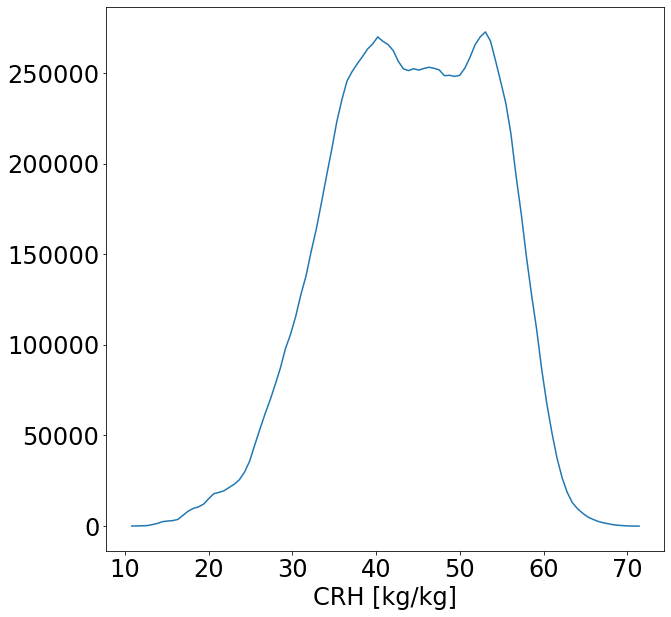

In [65]:
plt.figure(figsize=(10,10))
CWV_hist,bin_edges = np.histogram(PW.tcwv[:,:,:].sel({'time':'2016-10', 'latitude':slice(20,-5),'longitude':slice(310,350)}).values.flatten(),\
                                  bins=100)
bin_m = 0.5*(bin_edges[:-1]+bin_edges[1:])
plt.plot(bin_m,CWV_hist)
plt.xlabel('CRH [kg/kg]')

imin_tmp = np.argmin(CWV_hist[(bin_m<55)*(bin_m>45)])
ileft = np.argmax((bin_m<55)*(bin_m>45))
imin = ileft+imin_tmp
print(bin_m[imin])

CWV_sep = bin_m[imin]

# 1) Define WindMiller Index

In [263]:
# Average grid box area
Nx = PW.longitude.size
Ny = PW.latitude.size
A_earth = 510.1e6; # In km2
A_grid_avg = A_earth/(Nx*Ny)
dx_avg = np.sqrt(A_grid_avg)

AttributeError: 'int' object has no attribute 'sel'

In [285]:
def calc_WMI(CRH,dx,CRH_sep=None, slices=1, circle=False):
    ### Input: precipitable water field (time, x, y)
    ### dx = Average grid spacing
    ### CRH_sep = Value separating moist and dry regions
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ###
    ### Option: slices, slice longitude into s slices and compute averge WMI over subregions
    
    assert slices > 0, 'slices needs to be at least 1'
    
    if CRH_sep==None: CRH_median = np.median(CRH, axis=(1,2))
    else: CRH_sep = np.expand_dims(CRH_sep,axis=0)
    tmp = np.repeat(CRH_sep[:, np.newaxis], CRH.shape[1], axis=1)
    CRH_median_rep = np.repeat(tmp[:,:,np.newaxis],CRH.shape[2],axis=2)
    
    binary = CRH>CRH_median_rep
    binary = binary.values #Convert to numpy array

    #split region into n slices, assume that longitude is last dimension
    #Todo, change axis to whatever longitude is
    binary=np.array_split(binary, slices, axis=2)
    binary=np.asarray(binary)
    
    A_tot = np.sum(binary,axis=(2,3))*(dx**2)/1e12
    perimeter_tot = np.zeros(CRH.shape[0])
    

#    for it in range(len(np.median(CRH,axis=(1,2)))):
    for it in range(len(np.median(CRH,axis=(1,2)))):
      for s in range(slices): 
        #print("calculating time step %i"%it)
  
        label_im, nb_labels = ndimage.label(binary[s,it,:,:])      
        sizes = ndimage.sum(binary, label_im, range(nb_labels + 1)) #Sizes of connected area
        mask = sizes == max(sizes) #Only take the largest connected region
        binary_large = mask[label_im]
           
        #perimeter_tot[it] = dx*(measure.perimeter(binary[s,it,:,:],8) - measure.perimeter(binary[s,it,:,1:-2])/2)/1e6
        perimeter_tot[it] = dx*(measure.perimeter(binary[s,it,:,:],8) - measure.perimeter(binary[s,it,:,1:-2])/2)/1e6
        if it == 1:
            plt.imshow(binary_large)           
    print(np.shape(CRH)[2])
    if circle == True:
      WMI = np.mean(4*np.pi*A_tot/perimeter_tot**2, axis=0)
    else:
      #Compare contour to the width of the domain
      WMI = 2*np.shape(CRH)[2]*dx/1e6/perimeter_tot #Compare to the width of the domain

    return WMI

# 2) WindMiller Index for the Indian Ocean

161


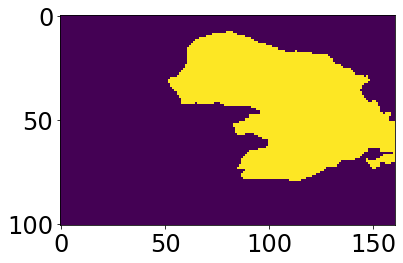

In [295]:
#water = PW.tcwv.sel({'time':'2016', 'latitude':slice(15,-15),'longitude':slice(40,160)}) - meanwater
WMI = calc_WMI(PW.tcwv.sel({'time':'2016-10', 'latitude':slice(20,-5),'longitude':slice(310,350)}),\
               dx_avg,CRH_sep=48)

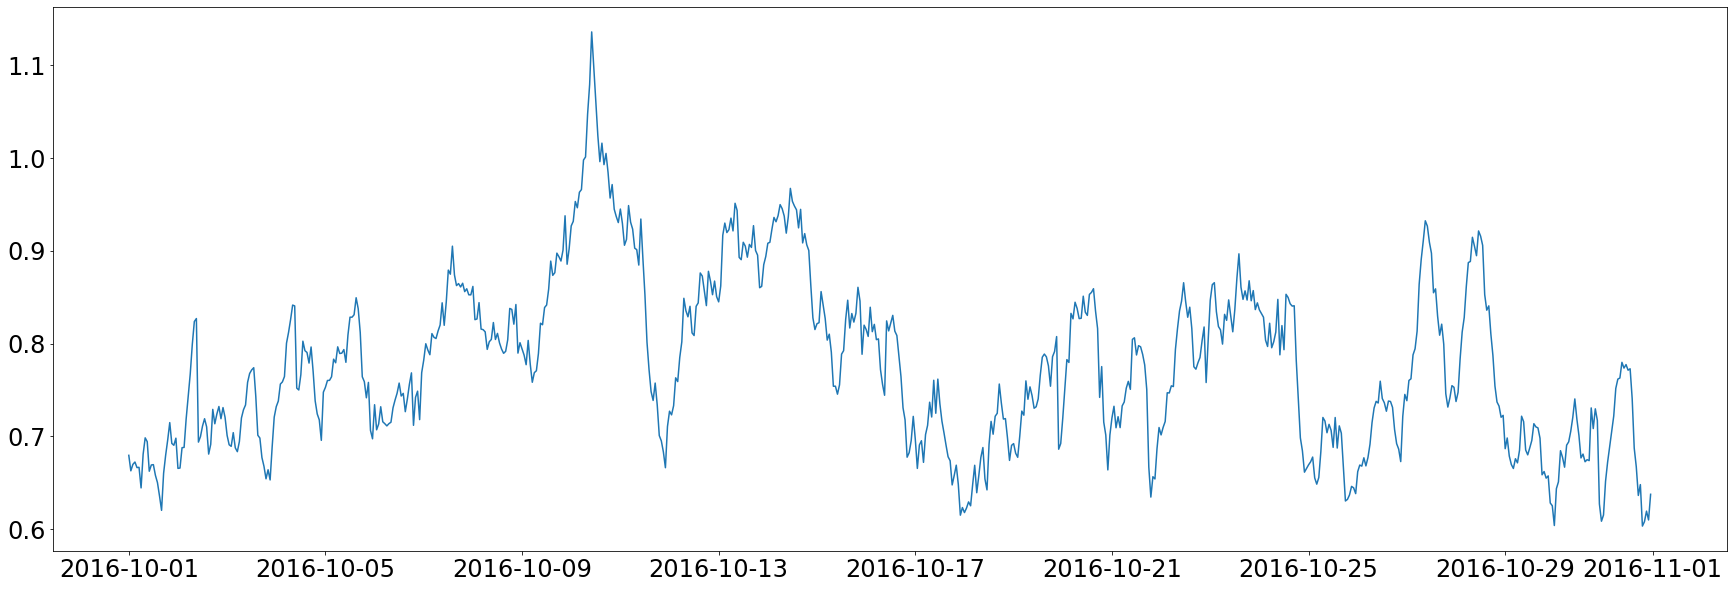

In [278]:
plt.figure(figsize=(30,10))
plt.plot(PW.time.sel({'time':'2016-10'}), WMI)

In [279]:
#T endency of Windmiller Index
dWMI = WMI[:-1] - WMI[1:]

(-0.1, 0.1)

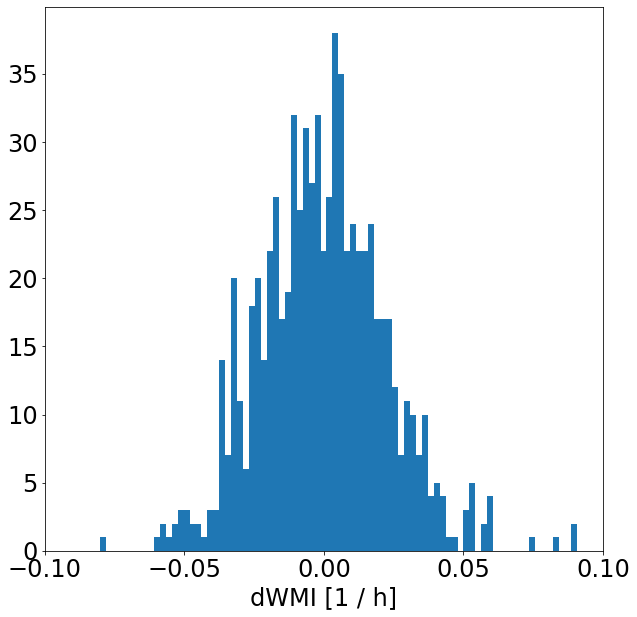

In [280]:
plt.figure(figsize=(10,10))
plt.hist(dWMI, bins=100)
plt.xlabel('dWMI [1 / h]')
plt.xlim(-0.1,0.1)

In [16]:
# Plot FFT of WMI timeseries

(0, 8784)

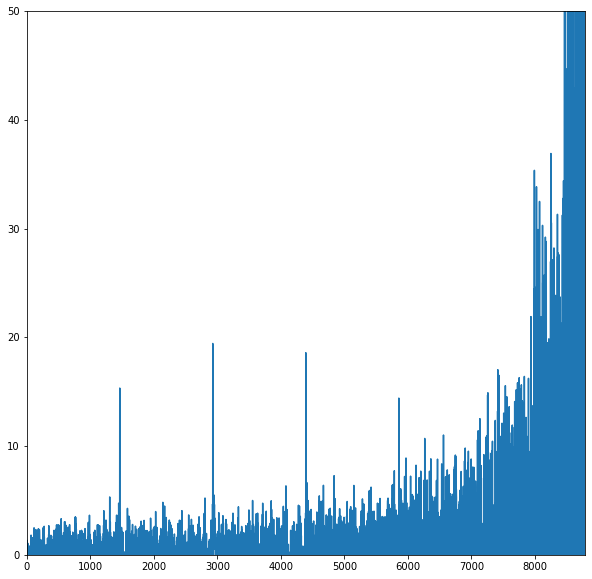

In [17]:
plt.figure(figsize=(10,10))
plt.plot(sp.fftpack.dct(WMI)[::-1])
plt.ylim(0,50)
plt.xlim(0,np.shape(WMI)[0])

array([1.00000000e+00, 9.98951894e-01, 9.97904887e-01, ...,
       1.00209951e-04, 1.00104921e-04, 1.00000000e-04])